In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4231829428662616702, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9214062756
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 972926104994060374
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
import sys
import time
import math
import os
import pandas as pd
import numpy as np

import keras
from keras import layers, metrics, models, optimizers
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, concatenate, Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0


In [5]:
batch_size = 16
img_rows, img_cols = 256, 256
input_shape = (img_rows, img_cols, 3)
epochs = 150

In [6]:
train_dir = 'data_augmented/cvc300_train/'
validation_dir = 'data_augmented/cvc300_validation/'
test_dir = 'data_augmented/cvc300_test/'

image_folder = 'images'
masks_folder = 'masks'

In [7]:
from keras.layers import Input
from keras.layers.core import Activation, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model


def SegNet(img_size):

    inputs = Input(shape=(img_size, img_size, 3))
    s = Lambda(lambda x: x / 255)(inputs)

    x = Conv2D(64, (3, 3), padding="same")(s)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(512, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(1, (1, 1), padding="valid")(x)
    x = Activation("sigmoid")(x)
    model = Model(inputs, x)
    return model

In [8]:
seed = 1142
data_gen_args = dict(rescale=1. / 255, featurewise_center=True, featurewise_std_normalization=True)
image_datagen = ImageDataGenerator(**data_gen_args)
masks_datagen = ImageDataGenerator(**data_gen_args)

test_datagen = ImageDataGenerator(rescale=1./255)

image_generator = image_datagen.flow_from_directory(
    train_dir,
    classes = [image_folder],
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

mask_generator = masks_datagen.flow_from_directory(
    train_dir,
    classes = [masks_folder],
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

validation_image_generator = image_datagen.flow_from_directory(
    validation_dir,
    classes = [image_folder],
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

validation_mask_generator = masks_datagen.flow_from_directory(
    validation_dir,
    classes = [masks_folder],
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

test_image_generator = test_datagen.flow_from_directory(
    test_dir,
    classes = [image_folder],
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

test_mask_generator = test_datagen.flow_from_directory(
    test_dir,
    classes = [masks_folder],
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

Found 26112 images belonging to 1 classes.
Found 26112 images belonging to 1 classes.
Found 8704 images belonging to 1 classes.
Found 8704 images belonging to 1 classes.
Found 28 images belonging to 1 classes.
Found 28 images belonging to 1 classes.


In [9]:
train_generator = zip(image_generator, mask_generator)
validation_generator = zip(validation_image_generator, validation_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)

In [10]:
nb_train_samples = len(image_generator.filenames)
nb_validation_samples = len(validation_image_generator.filenames)
nb_test_samples = len(test_image_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

nb_train_samples: 26112
nb_validation_samples: 8704
nb_test_samples: 28

predict_size_train: 1632
predict_size_validation: 544
predict_size_test: 2


In [11]:
smooth = 1.
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def Specificity(y_true, y_pred):
    true_negatives = K.abs(y_pred)- K.abs(y_true)
    return ((true_negatives+smooth)/(y_pred+ smooth))

def Sensitivity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return ((y_pred+smooth)/ (y_true+smooth))

def Jaccard_index(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))

In [12]:
model = SegNet(256)
model.summary()
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer= adam_opt, loss=dice_coef_loss, 
              metrics=[dice_coef, 'acc','mse', Jaccard_index, Specificity, Sensitivity, precision, recall, f1score])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
__________

In [13]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=nb_train_samples//batch_size,
                    epochs=epochs,
                    validation_data = validation_generator,
                    validation_steps = nb_validation_samples//batch_size)

Epoch 1/150
1632/1632 [==============================] - 550s 337ms/step - loss: -0.1265 - dice_coef: 0.1265 - acc: 0.5014 - mean_squared_error: 0.3654 - Jaccard_index: 0.0677 - Specificity: 0.9698 - Sensitivity: 1.4008 - precision: 0.0799 - recall: 0.6374 - f1score: 0.1414 - val_loss: -0.1910 - val_dice_coef: 0.1910 - val_acc: 0.5802 - val_mean_squared_error: 0.2707 - val_Jaccard_index: 0.1062 - val_Specificity: 0.9640 - val_Sensitivity: 1.3028 - val_precision: 0.1311 - val_recall: 0.6826 - val_f1score: 0.2186
Epoch 2/150
1632/1632 [==============================] - 510s 312ms/step - loss: -0.2839 - dice_coef: 0.2839 - acc: 0.7488 - mean_squared_error: 0.1051 - Jaccard_index: 0.1672 - Specificity: 0.9711 - Sensitivity: 1.1545 - precision: 0.2889 - recall: 0.6937 - f1score: 0.3995 - val_loss: -0.2336 - val_dice_coef: 0.2336 - val_acc: 0.6676 - val_mean_squared_error: 0.1814 - val_Jaccard_index: 0.1328 - val_Specificity: 0.9632 - val_Sensitivity: 1.2174 - val_precision: 0.1839 - val_rec

Epoch 17/150
1632/1632 [==============================] - 511s 313ms/step - loss: -0.8644 - dice_coef: 0.8644 - acc: 0.8379 - mean_squared_error: 0.0061 - Jaccard_index: 0.7622 - Specificity: 0.9745 - Sensitivity: 1.0030 - precision: 0.9495 - recall: 0.9196 - f1score: 0.9341 - val_loss: -0.2665 - val_dice_coef: 0.2665 - val_acc: 0.8190 - val_mean_squared_error: 0.0429 - val_Jaccard_index: 0.1554 - val_Specificity: 0.9480 - val_Sensitivity: 0.9776 - val_precision: 0.7857 - val_recall: 0.1622 - val_f1score: 0.2664
Epoch 18/150
1632/1632 [==============================] - 513s 314ms/step - loss: -0.8691 - dice_coef: 0.8691 - acc: 0.8381 - mean_squared_error: 0.0058 - Jaccard_index: 0.7695 - Specificity: 0.9746 - Sensitivity: 1.0030 - precision: 0.9529 - recall: 0.9253 - f1score: 0.9388 - val_loss: -0.2500 - val_dice_coef: 0.2500 - val_acc: 0.8164 - val_mean_squared_error: 0.0461 - val_Jaccard_index: 0.1449 - val_Specificity: 0.9478 - val_Sensitivity: 0.9802 - val_precision: 0.6481 - val_r

Epoch 33/150
1632/1632 [==============================] - 512s 314ms/step - loss: -0.8971 - dice_coef: 0.8971 - acc: 0.8393 - mean_squared_error: 0.0038 - Jaccard_index: 0.8143 - Specificity: 0.9754 - Sensitivity: 1.0028 - precision: 0.9747 - recall: 0.9637 - f1score: 0.9691 - val_loss: -0.3456 - val_dice_coef: 0.3456 - val_acc: 0.8184 - val_mean_squared_error: 0.0421 - val_Jaccard_index: 0.2111 - val_Specificity: 0.9500 - val_Sensitivity: 0.9827 - val_precision: 0.7232 - val_recall: 0.2371 - val_f1score: 0.3536
Epoch 34/150
1632/1632 [==============================] - 511s 313ms/step - loss: -0.8974 - dice_coef: 0.8974 - acc: 0.8393 - mean_squared_error: 0.0038 - Jaccard_index: 0.8147 - Specificity: 0.9754 - Sensitivity: 1.0028 - precision: 0.9750 - recall: 0.9640 - f1score: 0.9694 - val_loss: -0.3272 - val_dice_coef: 0.3272 - val_acc: 0.7814 - val_mean_squared_error: 0.0766 - val_Jaccard_index: 0.1972 - val_Specificity: 0.9539 - val_Sensitivity: 1.0304 - val_precision: 0.3310 - val_r

Epoch 49/150
1632/1632 [==============================] - 511s 313ms/step - loss: -0.9061 - dice_coef: 0.9061 - acc: 0.8398 - mean_squared_error: 0.0031 - Jaccard_index: 0.8293 - Specificity: 0.9756 - Sensitivity: 1.0028 - precision: 0.9826 - recall: 0.9765 - f1score: 0.9795 - val_loss: -0.1065 - val_dice_coef: 0.1065 - val_acc: 0.8122 - val_mean_squared_error: 0.0532 - val_Jaccard_index: 0.0566 - val_Specificity: 0.9450 - val_Sensitivity: 0.9792 - val_precision: 0.3438 - val_recall: 0.0638 - val_f1score: 0.1063
Epoch 50/150
1632/1632 [==============================] - 510s 313ms/step - loss: -0.9069 - dice_coef: 0.9069 - acc: 0.8398 - mean_squared_error: 0.0030 - Jaccard_index: 0.8306 - Specificity: 0.9757 - Sensitivity: 1.0028 - precision: 0.9834 - recall: 0.9777 - f1score: 0.9805 - val_loss: -0.3852 - val_dice_coef: 0.3852 - val_acc: 0.8085 - val_mean_squared_error: 0.0495 - val_Jaccard_index: 0.2401 - val_Specificity: 0.9525 - val_Sensitivity: 0.9981 - val_precision: 0.5407 - val_r

Epoch 65/150
1632/1632 [==============================] - 507s 311ms/step - loss: -0.9110 - dice_coef: 0.9110 - acc: 0.8400 - mean_squared_error: 0.0027 - Jaccard_index: 0.8373 - Specificity: 0.9758 - Sensitivity: 1.0027 - precision: 0.9871 - recall: 0.9827 - f1score: 0.9849 - val_loss: -0.1644 - val_dice_coef: 0.1644 - val_acc: 0.8178 - val_mean_squared_error: 0.0470 - val_Jaccard_index: 0.0904 - val_Specificity: 0.9458 - val_Sensitivity: 0.9746 - val_precision: 0.7085 - val_recall: 0.0942 - val_f1score: 0.1648
Epoch 66/150
1632/1632 [==============================] - 508s 311ms/step - loss: -0.9110 - dice_coef: 0.9110 - acc: 0.8400 - mean_squared_error: 0.0027 - Jaccard_index: 0.8374 - Specificity: 0.9758 - Sensitivity: 1.0027 - precision: 0.9873 - recall: 0.9829 - f1score: 0.9851 - val_loss: -0.2032 - val_dice_coef: 0.2032 - val_acc: 0.8197 - val_mean_squared_error: 0.0445 - val_Jaccard_index: 0.1145 - val_Specificity: 0.9465 - val_Sensitivity: 0.9740 - val_precision: 0.8728 - val_r

Epoch 81/150
1632/1632 [==============================] - 508s 311ms/step - loss: -0.9127 - dice_coef: 0.9127 - acc: 0.8401 - mean_squared_error: 0.0026 - Jaccard_index: 0.8403 - Specificity: 0.9758 - Sensitivity: 1.0027 - precision: 0.9891 - recall: 0.9852 - f1score: 0.9871 - val_loss: -0.0893 - val_dice_coef: 0.0893 - val_acc: 0.8175 - val_mean_squared_error: 0.0488 - val_Jaccard_index: 0.0473 - val_Specificity: 0.9445 - val_Sensitivity: 0.9723 - val_precision: 0.6430 - val_recall: 0.0482 - val_f1score: 0.0886
Epoch 82/150
1632/1632 [==============================] - 508s 311ms/step - loss: -0.9131 - dice_coef: 0.9131 - acc: 0.8401 - mean_squared_error: 0.0025 - Jaccard_index: 0.8410 - Specificity: 0.9758 - Sensitivity: 1.0027 - precision: 0.9895 - recall: 0.9857 - f1score: 0.9876 - val_loss: -0.4384 - val_dice_coef: 0.4384 - val_acc: 0.8113 - val_mean_squared_error: 0.0458 - val_Jaccard_index: 0.2829 - val_Specificity: 0.9539 - val_Sensitivity: 0.9982 - val_precision: 0.5910 - val_r

Epoch 97/150
1632/1632 [==============================] - 509s 312ms/step - loss: -0.9148 - dice_coef: 0.9148 - acc: 0.8402 - mean_squared_error: 0.0024 - Jaccard_index: 0.8439 - Specificity: 0.9759 - Sensitivity: 1.0027 - precision: 0.9911 - recall: 0.9879 - f1score: 0.9895 - val_loss: -0.3127 - val_dice_coef: 0.3127 - val_acc: 0.8196 - val_mean_squared_error: 0.0421 - val_Jaccard_index: 0.1872 - val_Specificity: 0.9488 - val_Sensitivity: 0.9787 - val_precision: 0.8129 - val_recall: 0.2019 - val_f1score: 0.3206
Epoch 98/150
1632/1632 [==============================] - 508s 312ms/step - loss: -0.9144 - dice_coef: 0.9144 - acc: 0.8401 - mean_squared_error: 0.0024 - Jaccard_index: 0.8432 - Specificity: 0.9759 - Sensitivity: 1.0027 - precision: 0.9909 - recall: 0.9875 - f1score: 0.9892 - val_loss: -0.2591 - val_dice_coef: 0.2591 - val_acc: 0.8188 - val_mean_squared_error: 0.0441 - val_Jaccard_index: 0.1505 - val_Specificity: 0.9477 - val_Sensitivity: 0.9771 - val_precision: 0.7817 - val_r

Epoch 113/150
1632/1632 [==============================] - 507s 311ms/step - loss: -0.9154 - dice_coef: 0.9154 - acc: 0.8402 - mean_squared_error: 0.0023 - Jaccard_index: 0.8448 - Specificity: 0.9759 - Sensitivity: 1.0026 - precision: 0.9919 - recall: 0.9887 - f1score: 0.9903 - val_loss: -0.0975 - val_dice_coef: 0.0975 - val_acc: 0.8180 - val_mean_squared_error: 0.0481 - val_Jaccard_index: 0.0519 - val_Specificity: 0.9446 - val_Sensitivity: 0.9720 - val_precision: 0.7260 - val_recall: 0.0520 - val_f1score: 0.0960
Epoch 114/150
1632/1632 [==============================] - 518s 318ms/step - loss: -0.9159 - dice_coef: 0.9159 - acc: 0.8402 - mean_squared_error: 0.0023 - Jaccard_index: 0.8457 - Specificity: 0.9759 - Sensitivity: 1.0026 - precision: 0.9923 - recall: 0.9893 - f1score: 0.9908 - val_loss: -0.2107 - val_dice_coef: 0.2107 - val_acc: 0.8036 - val_mean_squared_error: 0.0606 - val_Jaccard_index: 0.1190 - val_Specificity: 0.9478 - val_Sensitivity: 0.9946 - val_precision: 0.3384 - val

Epoch 129/150
1632/1632 [==============================] - 517s 317ms/step - loss: -0.9167 - dice_coef: 0.9167 - acc: 0.8402 - mean_squared_error: 0.0022 - Jaccard_index: 0.8471 - Specificity: 0.9759 - Sensitivity: 1.0026 - precision: 0.9933 - recall: 0.9904 - f1score: 0.9918 - val_loss: -0.0069 - val_dice_coef: 0.0069 - val_acc: 0.8176 - val_mean_squared_error: 0.0498 - val_Jaccard_index: 0.0035 - val_Specificity: 0.9432 - val_Sensitivity: 0.9695 - val_precision: 0.7051 - val_recall: 0.0032 - val_f1score: nan
Epoch 130/150
1632/1632 [==============================] - 516s 316ms/step - loss: -0.9160 - dice_coef: 0.9160 - acc: 0.8402 - mean_squared_error: 0.0023 - Jaccard_index: 0.8459 - Specificity: 0.9759 - Sensitivity: 1.0026 - precision: 0.9927 - recall: 0.9896 - f1score: 0.9911 - val_loss: -0.4900 - val_dice_coef: 0.4900 - val_acc: 0.8222 - val_mean_squared_error: 0.0345 - val_Jaccard_index: 0.3275 - val_Specificity: 0.9533 - val_Sensitivity: 0.9841 - val_precision: 0.8818 - val_re

Epoch 145/150
1632/1632 [==============================] - 508s 312ms/step - loss: -0.9170 - dice_coef: 0.9170 - acc: 0.8403 - mean_squared_error: 0.0022 - Jaccard_index: 0.8478 - Specificity: 0.9759 - Sensitivity: 1.0026 - precision: 0.9936 - recall: 0.9909 - f1score: 0.9922 - val_loss: -0.5611 - val_dice_coef: 0.5611 - val_acc: 0.8197 - val_mean_squared_error: 0.0336 - val_Jaccard_index: 0.3930 - val_Specificity: 0.9566 - val_Sensitivity: 0.9932 - val_precision: 0.7869 - val_recall: 0.4836 - val_f1score: 0.5946
Epoch 146/150
1632/1632 [==============================] - 509s 312ms/step - loss: -0.9172 - dice_coef: 0.9172 - acc: 0.8403 - mean_squared_error: 0.0022 - Jaccard_index: 0.8479 - Specificity: 0.9759 - Sensitivity: 1.0026 - precision: 0.9939 - recall: 0.9912 - f1score: 0.9925 - val_loss: -0.1209 - val_dice_coef: 0.1209 - val_acc: 0.8188 - val_mean_squared_error: 0.0470 - val_Jaccard_index: 0.0654 - val_Specificity: 0.9450 - val_Sensitivity: 0.9719 - val_precision: 0.8755 - val

In [14]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  -0.19155051320791244
Validation Accuracy:  0.19155051320791244


In [15]:
prediction = model.predict_generator(test_generator, verbose=1, steps=nb_test_samples)

28/28 [==============================] - 5s 174ms/step


In [16]:
prediction.shape

(392, 256, 256, 1)

In [30]:
test_results = model.evaluate_generator(test_generator, steps=50)

print(model.metrics_names)
print(test_results)

['loss', 'dice_coef', 'acc', 'mean_squared_error', 'Jaccard_index', 'Specificity', 'Sensitivity', 'precision', 'recall', 'f1score']
[-0.2636129552977426, 0.26361295453139716, 0.9570642110279628, 0.0425383888397898, 0.15343288110835213, 0.9541650104522705, 0.9796974291120256, 0.9050391905648367, 0.15552550094468254, 0.2630666926928929]


In [17]:
coef = np.array(history.history['Jaccard_index'])
val_coef = np.array(history.history['val_Jaccard_index'])
print("Training co-effiency    : {};\nValidation co-effiency : {}".format(coef[coef==max(coef)][0], val_coef[np.argmax(coef)]))

Training co-effiency    : 0.8481925048810595;
Validation co-effiency : 0.18517565130776562


In [18]:
import skimage.io as io

def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

os.mkdir('06.SegNet1_results_dir')

In [19]:
saveResult('06.SegNet1_results_dir',prediction)

In [20]:
def normalizeData(img,mask):
    mean = np.mean(img)
    std = np.std(img)
    img -= mean
    img /= std
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)

test_data_dir= "data_augmented/cvc300_test/images/"
test_data_mask_dir = "data_augmented/cvc300_test/masks/"
test_data_pred_dir = "06.SegNet1_results_dir"
img_rows, img_cols = 256, 256

In [21]:
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

file_names = next(os.walk(test_data_dir))[2]
scores = []
for file in file_names:
    grey_img = load_img(os.path.join(test_data_dir,file), target_size=(img_rows, img_cols), grayscale=False)
    mask_img = load_img(os.path.join(test_data_mask_dir,file), target_size=(img_rows, img_cols), grayscale=True)
    img = img_to_array(grey_img)
    img_mask = img_to_array(mask_img)
    
    img, img_mask = normalizeData(img, img_mask)
    img = np.reshape(img,(1,)+img.shape)
    
    pred = model.predict([img])
    sess = tf.Session()
    score = sess.run(Jaccard_index(img_mask, pred))
    print("{} -- jaccard index: {}".format(file,score))
    scores.append([file,score])

    result_img = array_to_img(pred[0] * 255 )
    result_img.save(os.path.join(test_data_pred_dir, file.split('.')[0] + '_predict.jpg'))

with open("segnet1_test_result.csv", 'w') as f:
    f.write("filename, jaccard_index\n")
    for i in range(len(scores)):
        #print(scores[i])
        f.write("{},{}\n".format(scores[i][0], scores[i][1]))

1.png -- jaccard index: 0.00048393054748885334
11.png -- jaccard index: 0.07397783547639847
113.png -- jaccard index: 0.6560110449790955
12.png -- jaccard index: 0.2904166281223297
144.png -- jaccard index: 0.412222683429718
156.png -- jaccard index: 0.1516391932964325
169.png -- jaccard index: 0.249680757522583
171.png -- jaccard index: 0.0653996542096138
175.png -- jaccard index: 0.4309198558330536
182.png -- jaccard index: 0.42662301659584045
185.png -- jaccard index: 0.33668380975723267
19.png -- jaccard index: 0.7439830303192139
193.png -- jaccard index: 0.3493901193141937
214.png -- jaccard index: 0.1748296320438385
23.png -- jaccard index: 0.5480345487594604
238.png -- jaccard index: 0.36330732703208923
239.png -- jaccard index: 0.5436392426490784
244.png -- jaccard index: 0.003782410640269518
246.png -- jaccard index: 0.3560684621334076
256.png -- jaccard index: 0.5518061518669128
269.png -- jaccard index: 0.07891912013292313
3.png -- jaccard index: 0.22850631177425385
42.png -

Populating the interactive namespace from numpy and matplotlib


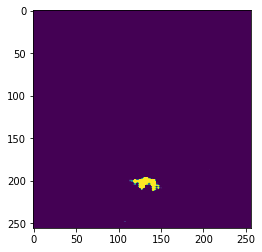

In [24]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('06.SegNet1_results_dir/104_predict.png')
imgplot = plt.imshow(img)
plt.show()

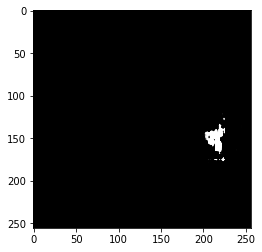

In [25]:
plt.imshow(np.squeeze(prediction[1]), cmap = "gray")

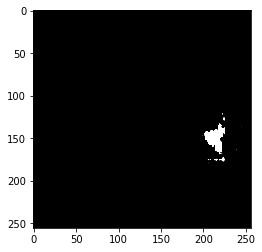

In [26]:
plt.imshow(np.squeeze(prediction[1]), cmap = "gray", vmin = 0.0, vmax= 0.09)

[[1.2132761e-09 1.6249433e-05 3.9374456e-05 ... 1.5388366e-07
  1.4622403e-09 1.7193921e-12]
 [2.5046516e-08 2.8889492e-06 6.0736504e-05 ... 1.2163662e-03
  5.4151138e-07 3.3162911e-07]
 [7.2613418e-08 6.2738283e-05 1.2843184e-04 ... 3.6346694e-04
  4.0347409e-06 1.2210256e-04]
 ...
 [3.5719634e-07 5.6007748e-06 1.6717117e-06 ... 6.2341474e-05
  3.6773305e-05 8.4162139e-06]
 [1.8784665e-06 3.5654899e-05 1.6867660e-05 ... 5.7604619e-05
  4.8798956e-06 3.7607020e-08]
 [1.0628542e-09 1.7290279e-08 4.0846120e-07 ... 6.9146841e-07
  3.7269709e-07 1.5565587e-09]]


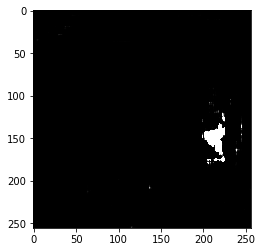

In [27]:
results_ =  np.squeeze(np.multiply(prediction[1], 255))
print(results_)

plt.imshow(results_, cmap = "gray", vmin = 0.0, vmax= 0.7)
plt.show()

Populating the interactive namespace from numpy and matplotlib


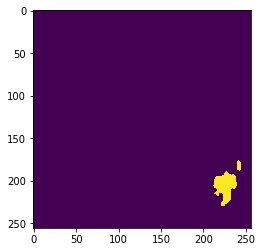

In [28]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('05.U-Net2_results_dir/35_predict.png')
imgplot = plt.imshow(img)
plt.show()

dict_keys(['val_Specificity', 'val_Sensitivity', 'Sensitivity', 'Jaccard_index', 'loss', 'val_dice_coef', 'val_Jaccard_index', 'dice_coef', 'precision', 'recall', 'val_acc', 'val_loss', 'val_mean_squared_error', 'mean_squared_error', 'acc', 'val_recall', 'f1score', 'val_precision', 'val_f1score', 'Specificity'])


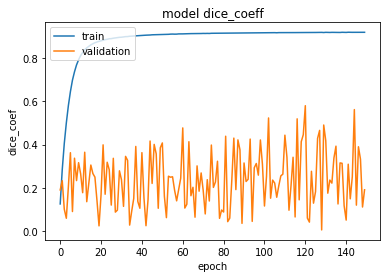

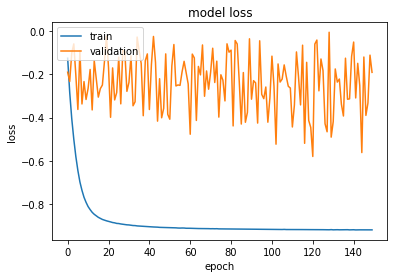

In [29]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice_coeff')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()